I'm not doing Exploratory Data Analysis (EDA) in this notebook, since there are quite a few notebooks with EDA already created. Instead my main goal is to achieve the highest F1 score (and through that the best AUC score obviously too). While analyzing the models predictions I realized from the very beginning that despite getting decent AUC scores all of them failed to provide sustainable precision. Their F1 score falls under 10%, which is unaccaptable in general. <br>
Unfortunately most of the published notebooks do not address this issue. <br>
This notebook provides comparison of leading models used for binary classification on tabular data. I also analyze how well these algorithms deal with categorical data being OneHot encoded vs being just encoded as labels.<br>
I also apply basic feature engineering to make a couple of synthetic features to see if that might help our models.<br>

<span style = 'font-size : medium; font-weight: bold; color : red'> Spoiler alert </span> - you can scroll down to find the curent winning solution at the bottom!<br>

<p style = 'font-size : medium; font-weight: bold; color : brown'> Please Upvote this notebook if you like my work. </p>

# Import libraries

In [1]:
import pandas as pd, numpy as np
import os
import math
from math import ceil, floor, log
import random

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report 
from sklearn.model_selection import train_test_split
import sklearn
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

from yellowbrick.classifier import ClassificationReport
import scikitplot as skplt

from xgboost import XGBClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
import catboost
print(catboost.__version__)
from catboost import *
from catboost import datasets
from catboost import CatBoostClassifier

import scikitplot as skplt

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


0.24.1


# Data loading and setup

In [2]:
SEED = 1970
random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
path = '../input/health-insurance-cross-sell-prediction/'

Data loading and preprocessing (feature engineering)...

Easy check proves that there is no empty or NaN data.

In [3]:
df_train = pd.read_csv(path + "train.csv")
df_test = pd.read_csv(path + "test.csv")
print(df_train.isnull().sum())
print(df_test.isnull().sum())

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64
id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64


In [4]:
col_list = df_train.columns.to_list()[1:]
df_train_corr = df_train.copy().set_index('id')
df_train_ones = df_train_corr.loc[df_train_corr.Response == 1].copy()

categorical_features = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage','Policy_Sales_Channel']
text_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

# code text categorical features
le = preprocessing.LabelEncoder()
for f in text_features :
    df_train_corr[f] = le.fit_transform(df_train_corr[f])
# change digital categorical datatype so CatBoost can deal with them
df_train_corr.Region_Code = df_train_corr.Region_Code.astype('int32')
df_train_corr.Policy_Sales_Channel = df_train_corr.Policy_Sales_Channel.astype('int32')

Lets check feature correlations.

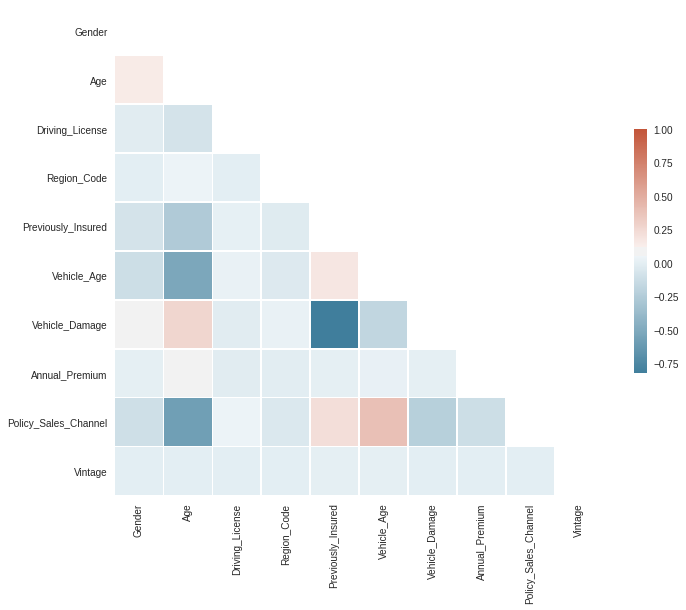

In [5]:
corr = df_train_corr.loc[:,:'Vintage'].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5})

Looks like we have pretty strong negative correlation between 'Vehicle_Damage' and 'Previously_Insured' features, worth exploring it later.

In [6]:
bins = [10,20, 30, 40, 50, 60, 70, 80, 90, 100]
df_train_corr['bin_age'] = pd.cut(df_train_corr['Age'], bins)
df_train_corr['bin_age']
df_train_corr['age_bin_cat'] = le.fit_transform(df_train_corr['bin_age'])
df_train_corr['age_bin_cat'].value_counts()

1    155229
3     75941
2     55163
4     45305
5     27838
6     15272
0      6232
7       129
Name: age_bin_cat, dtype: int64

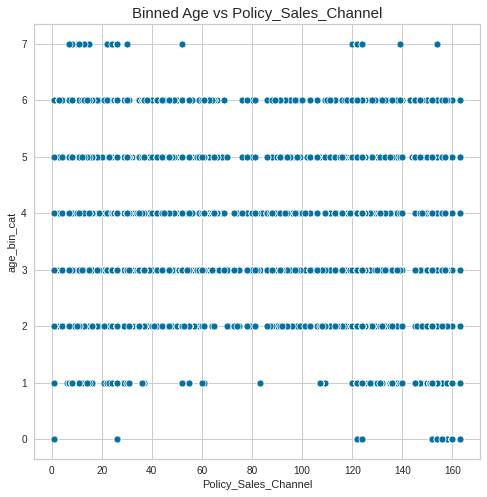

In [7]:
plt.figure(figsize = (8, 8))
sns.scatterplot(df_train_corr['Policy_Sales_Channel'],df_train_corr['age_bin_cat'])
# sns.scatterplot(df_train_corr['age_bin_cat'],df_train_corr['Policy_Sales_Channel'])
plt.title('Binned Age vs Policy_Sales_Channel', fontsize = 15)
plt.show()

In [8]:
X = df_train_corr.loc[:,:'Vintage']
y = df_train_corr.Response
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state = SEED)
        
print(y_train.value_counts())
X_train.head()

0    267547
1     37340
Name: Response, dtype: int64


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
id,,,,,,,,,,
74933,1,23,1,31,0,1,1,2630.0,160,52
74767,0,24,1,14,1,1,0,36238.0,152,223
46813,0,25,1,21,0,1,1,32979.0,152,169
56592,0,25,1,5,1,1,0,24476.0,152,202
109992,1,30,1,8,1,0,0,32797.0,26,211


In [9]:
def plot_ROC(fpr, tpr, m_name):
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Receiver operating characteristic for %s'%m_name, fontsize=20)
    plt.legend(loc="lower right", fontsize=16)
    plt.show()

# Baseline Tree Boosted models

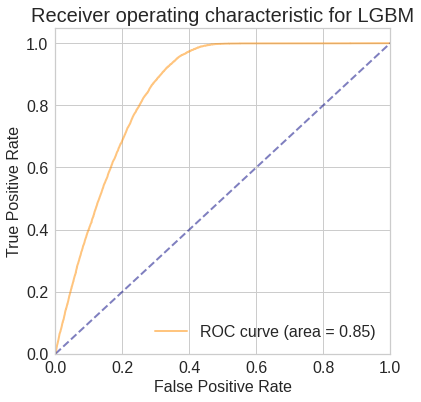

In [10]:
LGB_model = LGBMClassifier(random_state = SEED, max_depth = 8, n_estimators = 3000, reg_lambda = 1.2, reg_alpha = 1.2, min_child_weight = 1, verbose  = 1,
                       learning_rate = 0.15, gamma = 0.3, colsample_bytree = 0.5, eval_metric = 'auc', is_higher_better = 1, plot = True)
LGB_model.fit(X_train, y_train)
LGB_preds = LGB_model.predict_proba(X_valid)
LGB_class = LGB_model.predict(X_valid)
LGB_score = roc_auc_score(y_valid, LGB_preds[:,1])
(fpr, tpr, thresholds) = roc_curve(y_valid, LGB_preds[:,1])
plot_ROC(fpr, tpr, 'LGBM')

ROC AUC score for LGBM model: 0.8485
F1 score: 0.1368


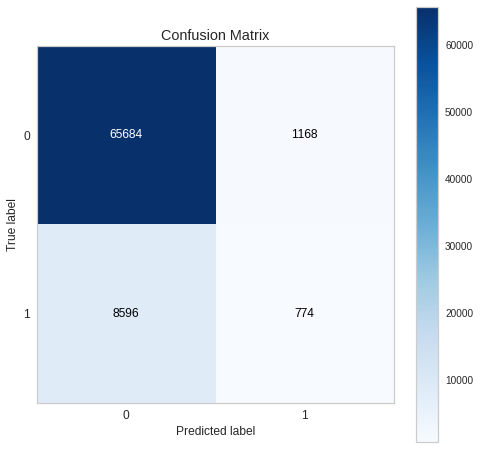

In [11]:
print('ROC AUC score for LGBM model: %.4f'%LGB_score)
print('F1 score: %0.4f'%f1_score(y_valid, LGB_class))
skplt.metrics.plot_confusion_matrix(y_valid, LGB_class, figsize=(8,8))

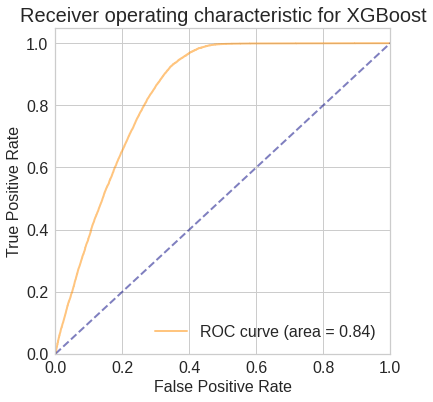

In [12]:
XGB_model = XGBClassifier(random_state = SEED, max_depth = 8, n_estimators = 3000, reg_lambda = 1.2, reg_alpha = 1.2, 
                          min_child_weight = 1, 
                          objective = 'binary:logistic',
                          learning_rate = 0.15, gamma = 0.3, colsample_bytree = 0.5, eval_metric = 'auc')
XGB_model.fit(X_train, y_train)
XGB_preds = XGB_model.predict_proba(X_valid)
XGB_class = XGB_model.predict(X_valid)
XGB_score = roc_auc_score(y_valid, XGB_preds[:,1])

(fpr, tpr, thresholds) = roc_curve(y_valid, XGB_preds[:,1])
plot_ROC(fpr, tpr, 'XGBoost')

ROC AUC score for XGBoost model: 0.8398
F1 score: 0.1972


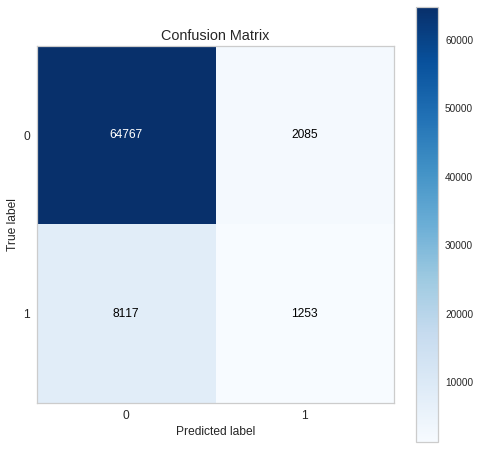

In [13]:
print('ROC AUC score for XGBoost model: %.4f'%XGB_score)
print('F1 score: %0.4f'%f1_score(y_valid, XGB_class))
skplt.metrics.plot_confusion_matrix(y_valid, XGB_class, figsize=(8,8))

0:	learn: 0.4705269	test: 0.4706803	best: 0.4706803 (0)	total: 270ms	remaining: 13m 29s
100:	learn: 0.2626571	test: 0.2645871	best: 0.2645871 (100)	total: 20.3s	remaining: 9m 42s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2644518246
bestIteration = 121

Shrink model to first 122 iterations.


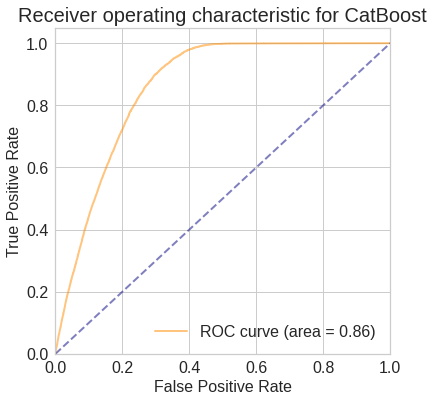

In [14]:
Cat_model = CatBoostClassifier(random_seed = SEED, 
                               iterations = 3000, 
                               task_type = 'CPU',
                               loss_function='Logloss',
                               eval_metric='Logloss',
                               cat_features = categorical_features,
                               leaf_estimation_method='Newton',
                               learning_rate = 0.15, 
                               subsample = 0.9,
                               rsm = 0.8,
                               custom_loss = ['AUC'] )

Cat_model.fit(X_train, y_train, cat_features = categorical_features, eval_set = (X_valid, y_valid), early_stopping_rounds=50, verbose = 1000, plot = False)
Cat_preds = Cat_model.predict_proba(X_valid)
Cat_class = Cat_model.predict(X_valid)
Cat_score = roc_auc_score(y_valid, Cat_preds[:,1])

(fpr, tpr, thresholds) = roc_curve(y_valid, Cat_preds[:,1])
plot_ROC(fpr, tpr, 'CatBoost')

ROC AUC score for CatBoost model: 0.8590
F1 score: 0.0295


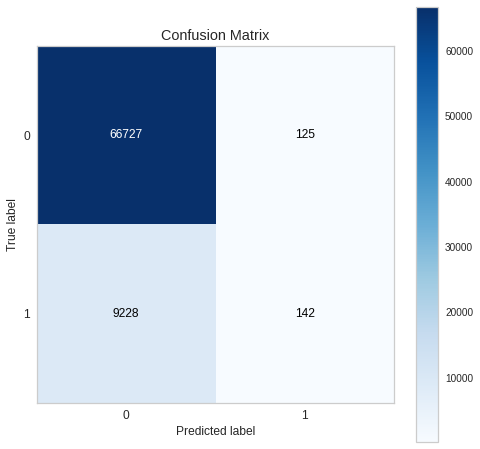

In [15]:
print('ROC AUC score for CatBoost model: %.4f'%Cat_score)
print('F1 score: %0.4f'%f1_score(y_valid, Cat_class))
skplt.metrics.plot_confusion_matrix(y_valid, Cat_class, figsize=(8,8))

Lets check if ensembling would give us some boost. <span style="text-decoration: line-through;">And it looks like it's not really helpful in this case. </span>After analyzing confusion matrices we actually see that all 3 models have terrible false negative rate, and underwhelming F1 score therefore (although somewhat decent AUC).  Moreover averaged result is even worse despite slightly increasing AUC  :(

# Ensembling attempt

Averaged score: 0.8525
Averaged F1 score: 0.0147


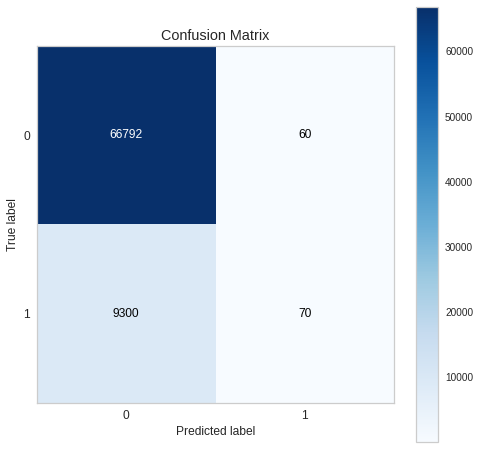

In [16]:
# simple averaging
avg_preds3 = (Cat_preds+LGB_preds+XGB_preds)/3
avg_class3 = ((Cat_class+LGB_class+XGB_class)/3).astype('int32')
score_avg3 = roc_auc_score(y_valid, avg_preds3[:,1], average = 'weighted')
print('Averaged score: %.4f'%score_avg3)
print('Averaged F1 score: %.4f'%f1_score(y_valid, avg_class3))
skplt.metrics.plot_confusion_matrix(y_valid, avg_class3, figsize=(8,8))

# One Hot Encoding categorical features

Now lets check if converting remaining categorical values to one-hot encoded features would help XGBoost.

In [17]:
df_train_01 = df_train.copy().set_index('id')
for f in categorical_features:
    df_train_01[f] = le.fit_transform(df_train_01[f])

# df_train_01.head()
y01 = df_train_01.Response
X01 = df_train_01.loc[:,:'Vintage']

sales = pd.get_dummies(X01.Policy_Sales_Channel, prefix = 'Sales')
code =  pd.get_dummies(X01.Region_Code, prefix = 'Code')
vehicle_age = pd.get_dummies(X01.Vehicle_Age, prefix = 'Vehicle_Age')
X_one_hot = pd.concat([X01, sales], axis = 1)
X_one_hot = pd.concat([X_one_hot, code], axis = 1)
X_one_hot = pd.concat([X_one_hot, vehicle_age], axis = 1)
X_one_hot = X_one_hot.drop(columns = ['Policy_Sales_Channel','Region_Code', 'Vehicle_Age'])
print(X_one_hot.columns)

Index(['Gender', 'Age', 'Driving_License', 'Previously_Insured', 'Vehicle_Damage', 'Annual_Premium', 'Vintage', 'Sales_0', 'Sales_1', 'Sales_2',
       ...
       'Code_46', 'Code_47', 'Code_48', 'Code_49', 'Code_50', 'Code_51', 'Code_52', 'Vehicle_Age_0', 'Vehicle_Age_1', 'Vehicle_Age_2'], dtype='object', length=218)


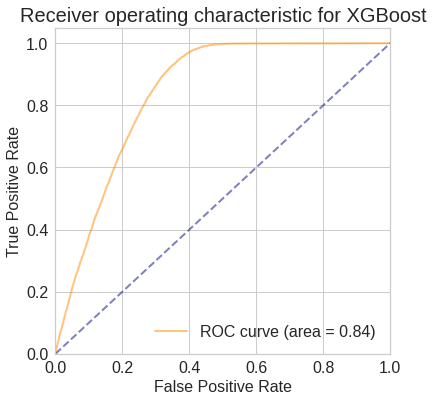

In [18]:
X0_train, X0_valid, y0_train, y0_valid = train_test_split(X_one_hot, y01, train_size=0.8, random_state = SEED)

XGB_model_01 = XGBClassifier(random_state = SEED, max_depth = 8, n_estimators = 3000, reg_lambda = 1.2, reg_alpha = 1.2, 
                          min_child_weight = 1, 
                          objective = 'binary:logistic',
                          learning_rate = 0.15, gamma = 0.3, colsample_bytree = 0.5, eval_metric = 'auc')
XGB_model_01.fit(X0_train, y0_train)
XGB_preds01 = XGB_model_01.predict_proba(X0_valid)
XGB_score01 = roc_auc_score(y0_valid, XGB_preds01[:,1])
XGB_class01 = XGB_model_01.predict(X0_valid)

(fpr, tpr, thresholds) = roc_curve(y0_valid, XGB_preds01[:,1])
plot_ROC(fpr, tpr,'XGBoost')

In [19]:
print('ROC AUC score for XGBoost model with One Hot Encoded categorical features: %.4f'%XGB_score01)
print('F1 score: %0.4f'%f1_score(y0_valid, XGB_class01))
print('Confusion matrix:')
print(confusion_matrix(y0_valid, XGB_class01))
# and for easier comparison lets do it again here
print('-'*20)
print('ROC AUC score for XGBoost model with categorical features not encoded: %.4f'%XGB_score)
print('F1 score: %0.4f'%f1_score(y_valid, XGB_class))
print('Confusion matrix with categorical features not encoded:')
print(confusion_matrix(y_valid, XGB_class))

ROC AUC score for XGBoost model with One Hot Encoded categorical features: 0.8408
F1 score: 0.1838
Confusion matrix:
[[65006  1846]
 [ 8235  1135]]
--------------------
ROC AUC score for XGBoost model with categorical features not encoded: 0.8398
F1 score: 0.1972
Confusion matrix with categorical features not encoded:
[[64767  2085]
 [ 8117  1253]]


Looks like in this case the same model performs better when categorical features are not one-hot encoded. AUCs are almost equal, however the f1 score is better for not encoded approach, about 10%.<br>  
Nevertheless both precisions are terrible still...

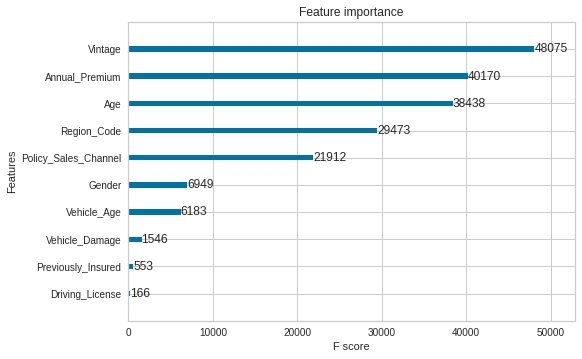

In [20]:
xgb.plot_importance(XGB_model)

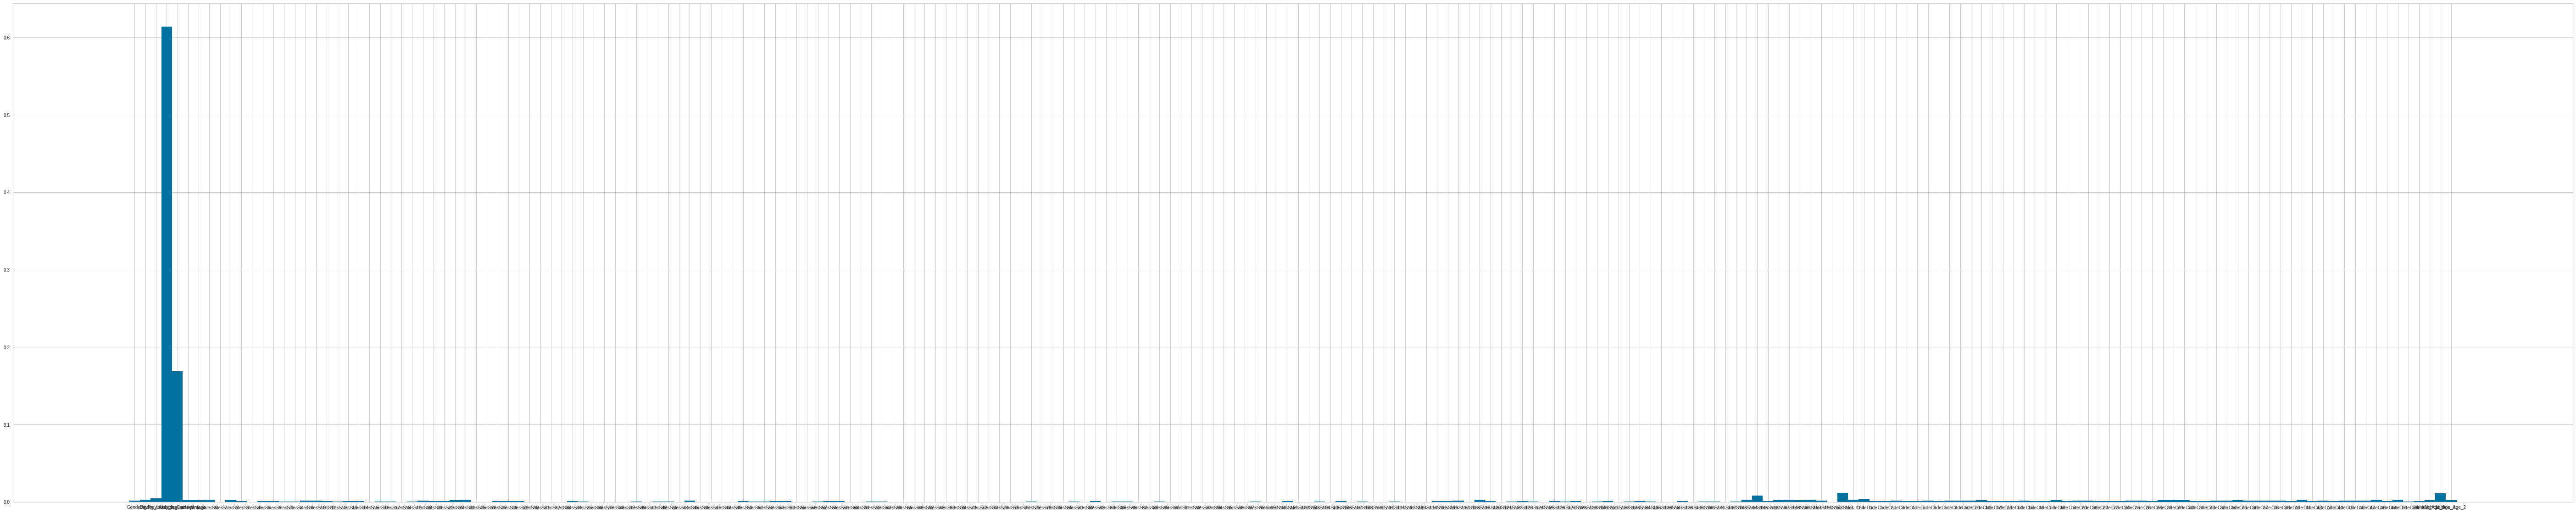

In [21]:
plt.figure(figsize=(100, 20))
plt.bar(X0_train.columns,XGB_model_01.feature_importances_, 1)
plt.show()

It's difficult to see exact feature names that influenced the model the most, but it's clearly ones from the original set of not one-hot encoded. Some of the encoded features also had some importance although few times less impactful.

Now lets try to deal with imbalance of the classes via built-in 'scale_pos_weight', although most likely it won't help much. I'll continue experimienting with XGBoost as it seems to be getting slightly better results.

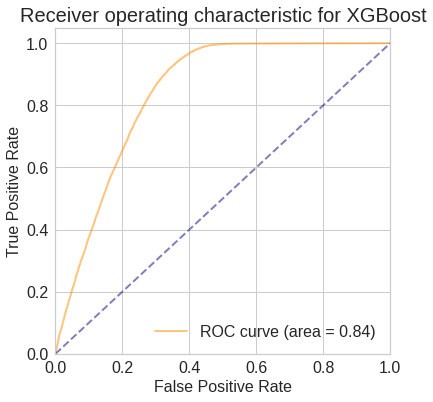

In [22]:
XGB_model_b = XGBClassifier(random_state = SEED, max_depth = 8, n_estimators = 3000, reg_lambda = 1.2, reg_alpha = 1.2, 
                          min_child_weight = 1, 
                          scale_pos_weight = 0.9,
                          objective = 'binary:logistic',
                          learning_rate = 0.15, gamma = 0.3, colsample_bytree = 0.5, eval_metric = 'auc')

XGB_model_b.fit(X_train, y_train)
XGB_preds_b = XGB_model_b.predict_proba(X_valid)
XGB_score_b = roc_auc_score(y_valid, XGB_preds_b[:,1])
XGB_class_b = XGB_model_b.predict(X_valid)

(fpr, tpr, thresholds) = roc_curve(y_valid, XGB_preds_b[:,1])
plot_ROC(fpr, tpr,'XGBoost')

ROC AUC score for XGBoost model: 0.8399
F1 score: 0.1825


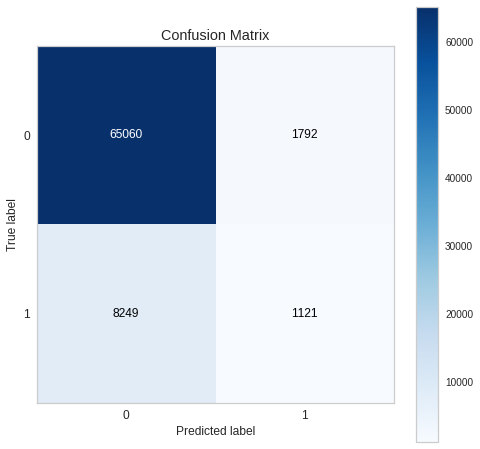

In [23]:
print('ROC AUC score for XGBoost model: %.4f'%XGB_score_b)
print('F1 score: %0.4f'%f1_score(y_valid, XGB_class_b))
skplt.metrics.plot_confusion_matrix(y_valid, XGB_class_b, figsize=(8,8))

As expected there is no improvement.

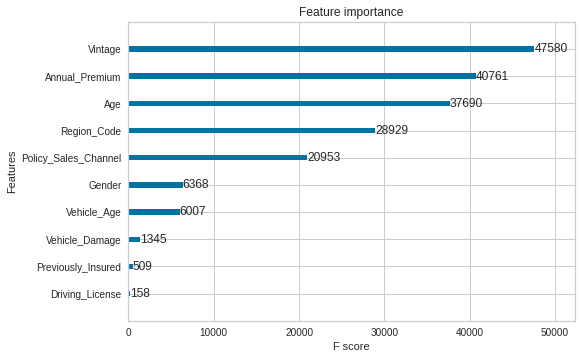

In [24]:
xgb.plot_importance(XGB_model_b)

Brute-force oversampling of Positive Response class, and engineering 2 new synthetic features

In [25]:
def upsample_all(df, n_upsampling):
    ones = df.copy()
    for n in range(n_upsampling):
        df['Annual_Premium'] = ones['Annual_Premium'].apply(lambda x: x + random.randint(-1,1)* x *0.1)
        df['Age'] = ones['Age'].apply(lambda x: x + random.randint(-5,5))
        df['Vintage'] = ones['Vintage'].apply(lambda x: x + random.randint(-5,5))
                
        if n == 0:
            df_new = df.copy()
        else:
            df_new = pd.concat([df_new, df])
    return df_new

def upsample(df, u_feature, n_upsampling):
    ones = df.copy()
    for n in range(n_upsampling):
        if u_feature == 'Annual_Premium':
            df[u_feature] = ones[u_feature].apply(lambda x: x + random.randint(-1,1)* x *0.05) # change Annual_premiun in the range of 5%
        else:
            df[u_feature] = ones[u_feature].apply(lambda x: x + random.randint(-5,5)) # change Age in the range of 5 years
                
        if n == 0:
            df_new = df.copy()
        else:
            df_new = pd.concat([df_new, df])
    return df_new

try:
    df_train_corr.drop(columns = ['bin_age'], inplace = True)
except:
    print('already deleted')        

df_train_mod = df_train_corr.copy()
df_train_mod['old_damaged'] = df_train_mod.apply(lambda x: pow(2,x.Vehicle_Age)+pow(2,x.Vehicle_Damage), axis =1)

# we shall preserve validation set without augmentation/over-sampling
dft, X_valid, yft, y_valid = train_test_split(df_train_mod, df_train_mod['Response'], train_size=0.8, random_state = SEED)
X_valid = X_valid.drop(columns = ['Response'])

# upsampling Positive Response class only
df_train_up_a = upsample(dft.loc[dft['Response'] == 1], 'Age', 1)
df_train_up_v = upsample(dft.loc[dft['Response'] == 1], 'Vintage', 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [26]:
df_train_mod.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,age_bin_cat,old_damaged
id,,,,,,,,,,,,,
1,1,44,1,28,0,2,1,40454.0,26,217,1,3,6.0
2,1,76,1,3,0,0,0,33536.0,26,183,0,6,2.0
3,1,47,1,28,0,2,1,38294.0,26,27,1,3,6.0
4,1,21,1,11,1,1,0,28619.0,152,203,0,1,3.0
5,0,29,1,41,1,1,0,27496.0,152,39,0,1,3.0


In [27]:
df_ext = pd.concat([df_train_mod,df_train_up_a])
df_ext = pd.concat([df_ext,df_train_up_v])
Xe = df_ext.drop(columns = ['Response'])
ye = df_ext.Response
print(ye.value_counts())
Xe.head()

0    334399
1    121390
Name: Response, dtype: int64


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,age_bin_cat,old_damaged
id,,,,,,,,,,,,
1,1,44,1,28,0,2,1,40454.0,26,217,3,6.0
2,1,76,1,3,0,0,0,33536.0,26,183,6,2.0
3,1,47,1,28,0,2,1,38294.0,26,27,3,6.0
4,1,21,1,11,1,1,0,28619.0,152,203,1,3.0
5,0,29,1,41,1,1,0,27496.0,152,39,1,3.0


In [28]:
X_train = Xe.copy()
y_train = ye.copy()
print('Validation set target class count: ')
print(y_valid.value_counts())
print('Train set target class count with over-sampling:')
print(ye.value_counts())

Validation set target class count: 
0    66852
1     9370
Name: Response, dtype: int64
Train set target class count with over-sampling:
0    334399
1    121390
Name: Response, dtype: int64


In [29]:
X_train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,age_bin_cat,old_damaged
id,,,,,,,,,,,,
1,1,44,1,28,0,2,1,40454.0,26,217,3,6.0
2,1,76,1,3,0,0,0,33536.0,26,183,6,2.0
3,1,47,1,28,0,2,1,38294.0,26,27,3,6.0
4,1,21,1,11,1,1,0,28619.0,152,203,1,3.0
5,0,29,1,41,1,1,0,27496.0,152,39,1,3.0


Now we are going to check how XGBoost with the same parameters as before will predict using upsampled data with new features.

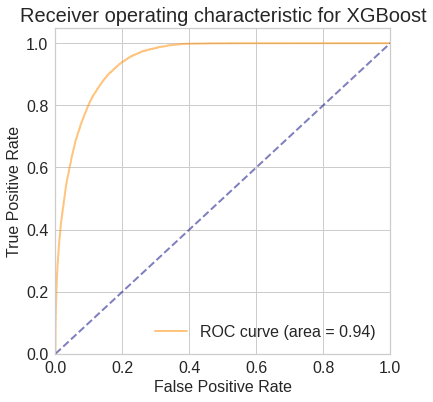

In [30]:
XGB_model_u = XGBClassifier(random_state = SEED, max_depth = 8, n_estimators = 3000, reg_lambda = 1.2, reg_alpha = 1.2, 
                          min_child_weight = 1, 
                          objective = 'binary:logistic',
                          learning_rate = 0.15, gamma = 0.3, colsample_bytree = 0.5, eval_metric = 'auc')

XGB_model_u.fit(X_train, y_train)
XGB_preds_u = XGB_model_u.predict_proba(X_valid)
XGB_score_u = roc_auc_score(y_valid, XGB_preds_u[:,1])
XGB_class_u = XGB_model_u.predict(X_valid)

(fpr, tpr, thresholds) = roc_curve(y_valid, XGB_preds_u[:,1])
plot_ROC(fpr, tpr,'XGBoost')

ROC AUC score for XGBoost model with over-sampling + 2 new features: 0.9438
F1 score: 0.6418


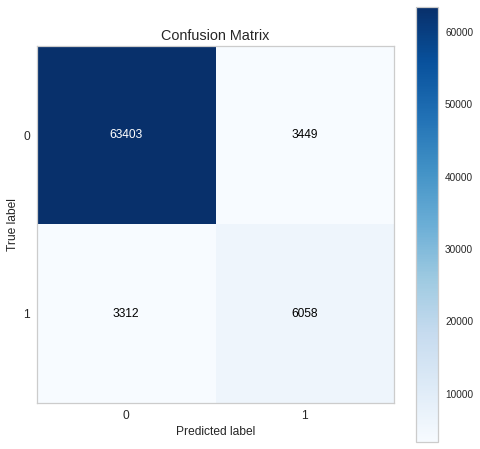

In [31]:
print('ROC AUC score for XGBoost model with over-sampling + 2 new features: %.4f'%XGB_score_u)
print('F1 score: %0.4f'%f1_score(y_valid, XGB_class_u))
skplt.metrics.plot_confusion_matrix(y_valid, XGB_class_u,
        figsize=(8,8))

Now we got much better True Positives,and quite acceptable AUC and f1 scores.

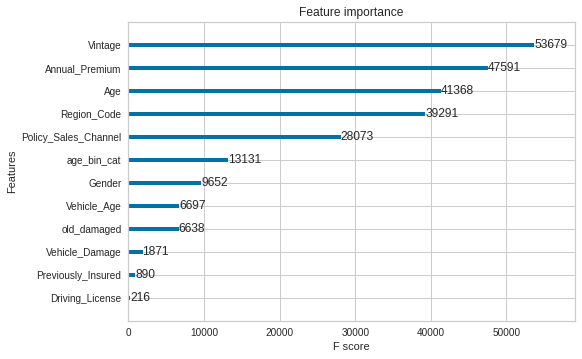

In [32]:
xgb.plot_importance(XGB_model_u)

Since we saw that 2 features were correlated: 'Previously_Insured' and 'Vehicle_Damage', and the former is less significant for the decision making we'd drop it.

In [33]:
X_train.drop(columns = ['Previously_Insured', 'Driving_License','Vehicle_Age','Vehicle_Damage'], inplace = True)
X_valid.drop(columns = ['Previously_Insured', 'Driving_License','Vehicle_Age','Vehicle_Damage'], inplace = True)
# X_train.drop(columns = ['Previously_Insured'], inplace = True)
# X_valid.drop(columns = ['Previously_Insured'], inplace = True)

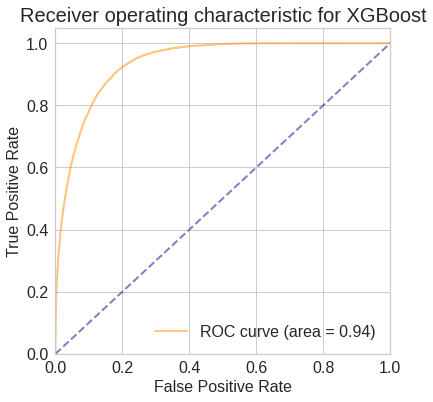

In [34]:
XGB_model_ud = XGBClassifier(random_state = SEED, max_depth = 8, n_estimators = 3000, reg_lambda = 1.2, reg_alpha = 1.2, 
                          min_child_weight = 1, 
                          objective = 'binary:logistic',
                          learning_rate = 0.15, gamma = 0.3, colsample_bytree = 0.5, eval_metric = 'auc')

XGB_model_ud.fit(X_train, y_train)
XGB_preds_ud = XGB_model_ud.predict_proba(X_valid)
XGB_score_ud = roc_auc_score(y_valid, XGB_preds_ud[:,1])
XGB_class_ud = XGB_model_ud.predict(X_valid)

(fpr, tpr, thresholds) = roc_curve(y_valid, XGB_preds_ud[:,1])
plot_ROC(fpr, tpr,'XGBoost')

ROC AUC score for XGBoost model with over-sampling, and 4 features removed: 0.9371
F1 score: 0.6282


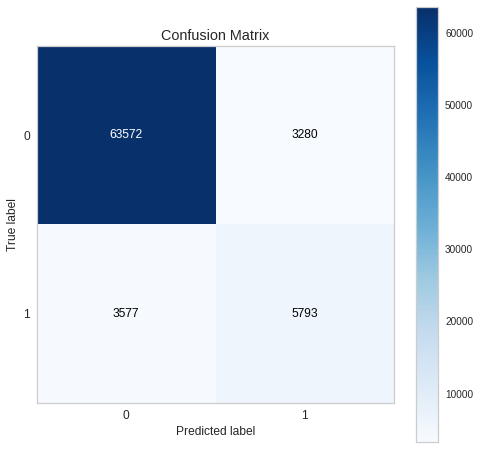

In [35]:
print('ROC AUC score for XGBoost model with over-sampling, and 4 features removed: %.4f'%XGB_score_ud)
print('F1 score: %0.4f'%f1_score(y_valid, XGB_class_ud))
skplt.metrics.plot_confusion_matrix(y_valid, XGB_class_ud,
        figsize=(8,8))

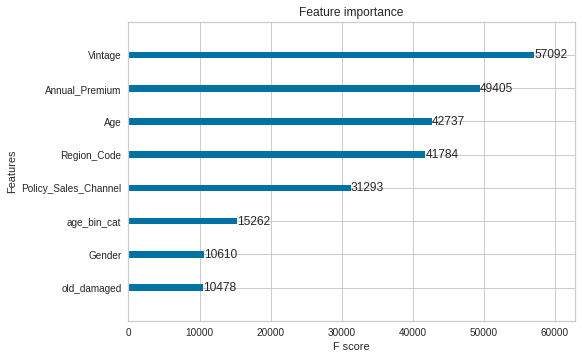

In [36]:
xgb.plot_importance(XGB_model_ud)

And it seems that dropping these features that were seemingly unimportant actually worsens the prediction...

Time to compare boosted trees with classical approaches like Random Forest, working with OneHot encoded categorical features

In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaled = scaler.fit_transform(X_one_hot[['Age','Vintage', 'Annual_Premium']])
X_one_hot_scaled = X_one_hot.copy()
X_one_hot_scaled[['Age','Vintage', 'Annual_Premium']] = scaled

X0_train_scaled, X0_valid_scaled, y0_train, y0_valid = train_test_split(X_one_hot_scaled, y01, train_size=0.8, random_state = SEED)

ROC AUC score for Random Forest model with categorical features one-hot-encoded: 0.8562
Random Forest f1-score 0.0006399317406143343


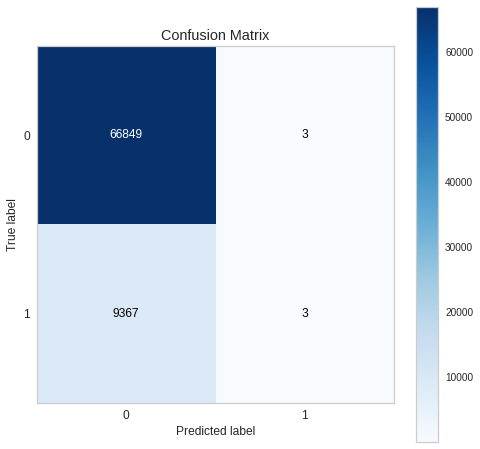

In [38]:
# just a reminder that X_train, y_train contain engineered features and twice oversampled, while X0_train, y0_train is for OneHotEncoded categoticals without oversampling

rf_params = {'max_depth': 20, 'n_estimators': 3000, 'min_samples_leaf': 1}
rf_params['random_state'] = SEED
rf = RandomForestClassifier(**rf_params)
rf.fit(X0_train, y0_train)
rf_preds = rf.predict(X0_valid)
rf_preds_prob = rf.predict_proba(X0_valid)[:,1]

reg_score_uc = roc_auc_score(y0_valid, rf_preds_prob, average = 'weighted')
print('ROC AUC score for Random Forest model with categorical features one-hot-encoded: %.4f'%reg_score_uc)
print('Random Forest f1-score', f1_score(y0_valid, rf_preds))
skplt.metrics.plot_confusion_matrix(y0_valid, rf_preds,figsize=(8,8))

Using Random Forest we again get quite decent AUC score while F1 score is proving that the precision is still failing.<br>
Lets see how RF will deal with the augmented dataset, with new synthetic features and no one-hot encoding applied.

# Ex-Winner
RF gave it's top spot in the last 3 days, so it's not even the 2nd nowadays
> Random Forest applied to the augmented set with 2 engineered features got us the most remarkable score to date (9/25/2020):  AUC 92%, f1 56%, and I'm quite sure there is some room for improvement.

ROC AUC score for RandomForest model with over-sampling: 0.9199
Optimized RF f1-score 0.5649606299212598


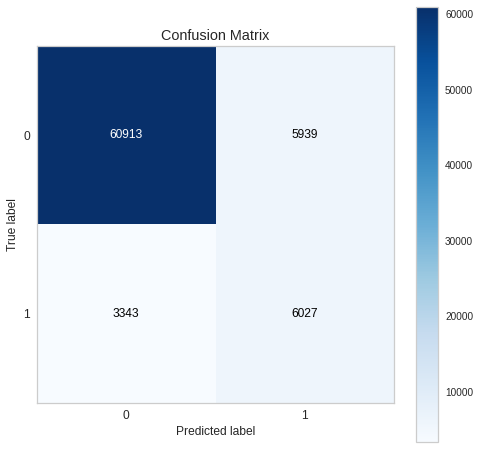

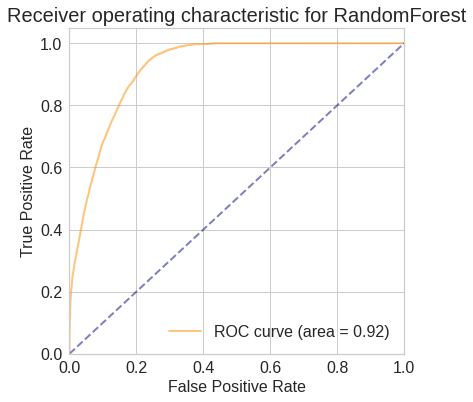

In [39]:
rf_params = {'max_depth': 20, 'n_estimators': 3000, 'min_samples_leaf': 1}
# rf_params = {'max_depth': 20, 'n_estimators': 300, 'min_samples_leaf': 1}
rf_params['random_state'] = SEED
rf = RandomForestClassifier(**rf_params)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_valid)
rf_preds_prob = rf.predict_proba(X_valid)[:,1]

reg_score_uc = roc_auc_score(y_valid, rf_preds_prob, average = 'weighted')
print('ROC AUC score for RandomForest model with over-sampling: %.4f'%reg_score_uc)
print('Optimized RF f1-score', f1_score(y_valid, rf_preds))
skplt.metrics.plot_confusion_matrix(y_valid, rf_preds,figsize=(8,8))

(fpr, tpr, thresholds) = roc_curve(y_valid, rf_preds_prob)
plot_ROC(fpr, tpr,'RandomForest')

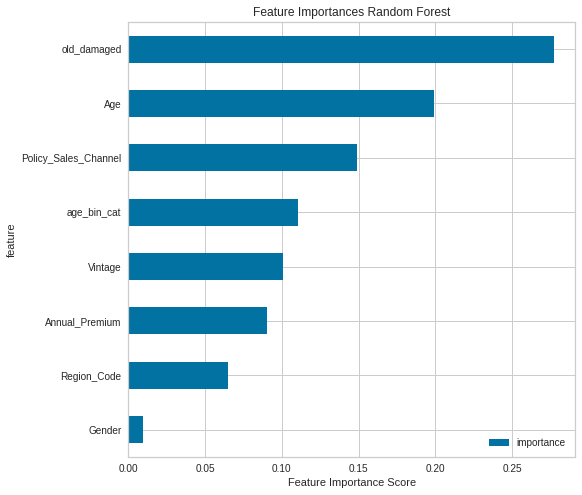

In [40]:
title="Feature Importances Random Forest"
feat_imp = pd.DataFrame({'importance':rf.feature_importances_}) 
feat_imp['feature'] = X_train.columns
feat_imp.sort_values(by='importance', ascending=True, inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=(8,8))
plt.xlabel('Feature Importance Score')
plt.show()
# rf.get_params()

# And the winner is...


As of 9/27/2020 **CatBoost** is top contender.<br>
And now lets try to improve CatBoost predictions. We will use it's built-in capabilities to deal with categorecal features. Hopefully it will work better than XGBoost with OneHot encoded features.<br>
I tried it starting from 3000 iterations when it gave worse result than RF, but looking at the confusion matrix I saw potential for more precise prediction. So I started slightly tunining the parameters to get better results.

In [41]:
categorical_features1 = ['Gender',
 'age_bin_cat',
 'Region_Code',
 'old_damaged',
 'Policy_Sales_Channel']

X_train.old_damaged = X_train.old_damaged.astype('int32')
X_valid.old_damaged = X_valid.old_damaged.astype('int32')

In [42]:
Cat_model1 = CatBoostClassifier( iterations = 30000, 
                                random_seed = SEED, 
#                                 task_type = 'GPU',
                                task_type = 'CPU',
                                learning_rate=0.15,
                                random_strength=0.1,
                                depth=8,
                                loss_function='Logloss',
                                eval_metric='Logloss',
                                leaf_estimation_method='Newton',
                                subsample = 0.9,
                                rsm = 0.8,
                                custom_loss = ['AUC'] )
Cat_model1.fit(X_train, y_train, cat_features = categorical_features1, eval_set = (X_valid, y_valid), plot = False,
              early_stopping_rounds=50,verbose = 1000)

0:	learn: 0.5917928	test: 0.5697016	best: 0.5697016 (0)	total: 615ms	remaining: 5h 7m 25s
1000:	learn: 0.3337355	test: 0.2866485	best: 0.2866485 (1000)	total: 7m 55s	remaining: 3h 49m 31s
2000:	learn: 0.3054884	test: 0.2725879	best: 0.2725879 (2000)	total: 16m 6s	remaining: 3h 45m 24s
3000:	learn: 0.2829619	test: 0.2609805	best: 0.2609714 (2998)	total: 24m 8s	remaining: 3h 37m 11s
4000:	learn: 0.2647131	test: 0.2517178	best: 0.2517178 (4000)	total: 32m 20s	remaining: 3h 30m 11s
5000:	learn: 0.2475697	test: 0.2425298	best: 0.2425278 (4998)	total: 40m 28s	remaining: 3h 22m 20s
6000:	learn: 0.2330903	test: 0.2345951	best: 0.2345951 (6000)	total: 48m 49s	remaining: 3h 15m 17s
7000:	learn: 0.2203722	test: 0.2279889	best: 0.2279889 (7000)	total: 57m	remaining: 3h 7m 16s
8000:	learn: 0.2081342	test: 0.2213153	best: 0.2213153 (8000)	total: 1h 5m 15s	remaining: 2h 59m 25s
9000:	learn: 0.1975189	test: 0.2150757	best: 0.2150757 (9000)	total: 1h 13m 25s	remaining: 2h 51m 16s
10000:	learn: 0.187588

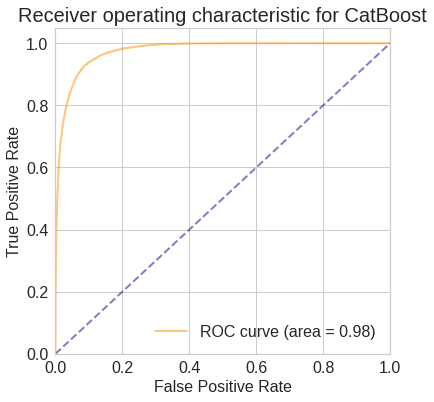

In [43]:
Cat_preds1 = Cat_model1.predict_proba(X_valid)
Cat_class1 = Cat_model1.predict(X_valid)
Cat_score1 = roc_auc_score(y_valid, Cat_preds1[:,1])

(fpr, tpr, thresholds) = roc_curve(y_valid, Cat_preds1[:,1])
plot_ROC(fpr, tpr, 'CatBoost')

ROC AUC score for CatBoost model with over-sampling: 0.9757
CatBoost f1-score 0.7840309910685461


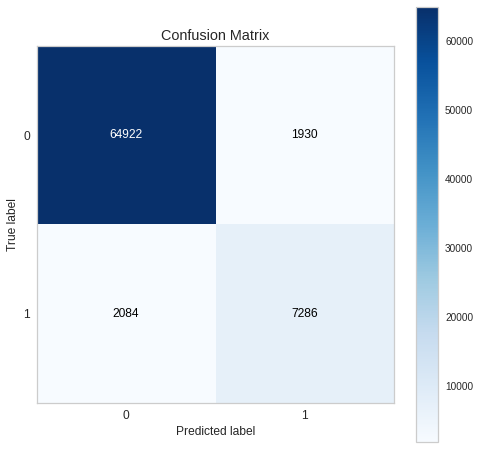

In [44]:
print('ROC AUC score for CatBoost model with over-sampling: %.4f'%Cat_score1)
print('CatBoost f1-score', f1_score(y_valid, Cat_class1))
skplt.metrics.plot_confusion_matrix(y_valid, Cat_class1,figsize=(8,8))

History of changes in parameters reflects how the scoring changes:
1. When parameters chosen as: ( iterations = 10000, random_seed = SEED, task_type = 'GPU', task_type = 'CPU', learning_rate=0.05, random_strength=0.1, depth=8,                                loss_function='Logloss', eval_metric='Logloss', leaf_estimation_method='Newton', subsample = 0.9, rsm = 0.8, custom_loss = ['AUC'] ) <br>
then we got: <br>
ROC AUC score for CatBoost model with over-sampling: 0.9111 <br>
CatBoost f1-score 0.5562159484893512
2. When I changed learning to 0.15 and limited iterations to 20000 I got: <br>
ROC AUC score for CatBoost model with over-sampling: 0.9659<br>
CatBoost f1-score 0.7399318133390156
3. When iterations were limited to 30000 it came to: <br>
ROC AUC score for CatBoost model with over-sampling: 0.9757
CatBoost f1-score 0.7840309910685461

# TO-DO
* <strike>Try to improve XGBoost and CatBoost through fine-tuning, and try to beat Random Forest on augmented data. </strike>    <br>
 We got CatBoost beating RandomForest and XGBoost successfully! Now we shall try to improve it even further :) <br>
* KFold croos-validation might help, but I don't expect it to give a breakthrough improvement, so it is a low priority for now. <br>
* And think of more feature engineering...<br>

<p style = 'font-size : medium; font-weight: bold; color : green'> More experiments coming. </p>

<strike>**Big question** - was AUC the right metric for this problem, or would F1 be better?</strike> <br>
<p style = 'font-size : medium; font-weight: bold; color : brown'> I'm quite sure now that the metric must be F1 for this task to produce usable predictions</p>